#### Visualizing the Data 

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [4]:
my_data_dir = 'C:\\Users\\DELL\\Downloads\\cell_images\\cell_images'

In [5]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [6]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [7]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [8]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [9]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [10]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [11]:
para_img= imread(para_cell)

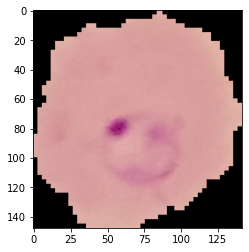

In [12]:
plt.imshow(para_img)

In [13]:
para_img.shape

(148, 142, 3)

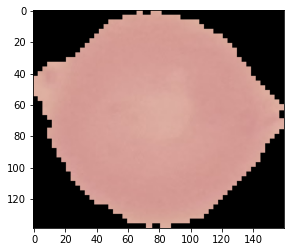

In [14]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

**Number of images.**

In [15]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [16]:
len(os.listdir(train_path+'\\uninfected'))

12480

**average dimensions of the images.**

In [17]:
unifected_cell.shape

(139, 160, 3)

In [18]:
para_img.shape

(148, 142, 3)

In [19]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

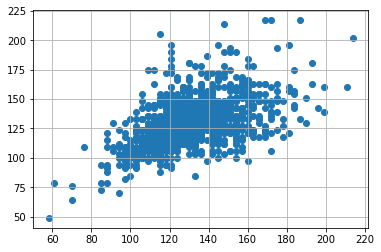

In [20]:
plt.scatter(dim1,dim2)
plt.grid()

In [21]:
np.mean(dim1)

130.92538461538462

In [22]:
np.mean(dim2)

130.75

In [23]:
image_shape = (130,130,3)

## Preparing the Data for the model

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

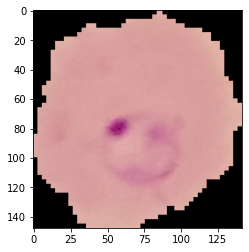

In [26]:
plt.imshow(para_img)

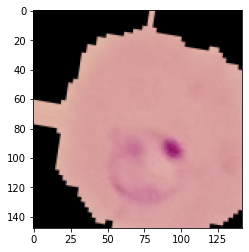

In [27]:
plt.imshow(image_gen.random_transform(para_img))

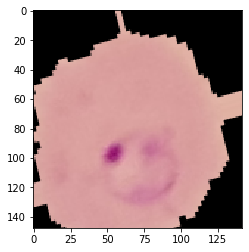

In [64]:
plt.imshow(image_gen.random_transform(para_img))

In [28]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [29]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [32]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

## Early Stopping

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [36]:
batch_size = 16

In [37]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [38]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [39]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 708s 453ms/step - loss: 0.6542 - accuracy: 0.5960 - val_loss: 0.6872 - val_accuracy: 0.5650
Epoch 2/20
1560/1560 [==============================] - 658s 422ms/step - loss: 0.5779 - accuracy: 0.6682 - val_loss: 0.2119 - val_accuracy: 0.9315
Epoch 3/20
1560/1560 [==============================] - 557s 356ms/step - loss: 0.2071 - accuracy: 0.9307 - val_loss: 0.1872 - val_accuracy: 0.9381
Epoch 4/20
1560/1560 [==============================] - 454s 291ms/step - loss: 0.1775 - accuracy: 0.9436 - val_loss: 0.1702 - val_accuracy: 0.9423
Epoch 5/20
1560/1560 [==============================] - 558s 358ms/step - loss: 0.1595 - accuracy: 0.9502 - val_loss: 0.1647 - val_accuracy: 0.9435
Epoch 6/20
1560/1560 [==============================] - 2153s 1s/step - loss: 0.1618 - accuracy: 0.9481 - val_loss: 0.1582 - val_accuracy: 0.9435
Epoch 7/20
1560/1560 [==============================] - 1717s 1s/step - loss: 0.1542 - accuracy: 0.9506 - val_loss

In [44]:
from tensorflow.keras.models import load_model
model.save('malaria_detector2.h5')

# Evaluating the Model

In [45]:
losses = pd.DataFrame(model.history.history)

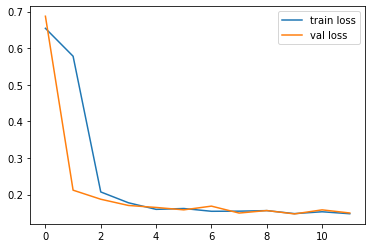

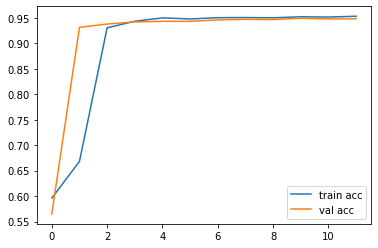

<Figure size 432x288 with 0 Axes>

In [46]:
# plot the loss
plt.plot(losses['loss'], label='train loss')
plt.plot(losses['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(losses['accuracy'], label='train acc')
plt.plot(losses['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [47]:
model.metrics_names

['loss', 'accuracy']

In [48]:
model.evaluate_generator(test_image_gen)

[0.1381901502609253, 0.9515384435653687]

In [49]:
from tensorflow.keras.preprocessing import image

In [50]:
pred_probabilities = model.predict_generator(test_image_gen)

In [51]:
pred_probabilities

array([[4.3740362e-04],
       [7.3120711e-05],
       [2.3286385e-03],
       ...,
       [9.3482602e-01],
       [9.7551072e-01],
       [9.2088675e-01]], dtype=float32)

In [52]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [53]:
predictions = pred_probabilities > 0.5

In [54]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [55]:
from sklearn.metrics import classification_report,confusion_matrix

In [56]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1300
           1       0.93      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [57]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1211,   89],
       [  41, 1259]], dtype=int64)

# Predicting on an Image

In [58]:
para_cell

'C:\\Users\\DELL\\Downloads\\cell_images\\cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [59]:
my_image = image.load_img(para_cell,target_size=image_shape)

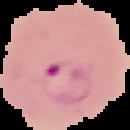

In [60]:
my_image

In [61]:
my_image = image.img_to_array(my_image)

In [62]:
type(my_image)

numpy.ndarray

In [63]:
my_image.shape

(130, 130, 3)

In [64]:
my_image = np.expand_dims(my_image, axis=0)

In [65]:
my_image.shape

(1, 130, 130, 3)

In [66]:
model.predict(my_image)

1/1 [==============================] - 0s 289ms/step


array([[0.]], dtype=float32)

In [67]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [68]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}